In [2]:
! pip install tensorflow_datasets

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.7 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 81 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 36.2 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=ee27f8aedd0854ddf85a9b75b277d8a7af4d0ba44a7363e14463f8e392aa6227
  Stored in directory: /home/lab11/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=ce6dd2763beda5498a6d9b8c6d2d6d25f9905d76128eb16651d6058855c47d51
  Stored in directory: /home/lab11/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
Successfully built future promise


In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /home/lab11/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/home/lab11/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo 

In [6]:
def load_image(datapoint):
    img = tf.image.resize(datapoint['image'],(128,128))
    mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))
    
    img = tf.cast(img, tf.float32)
    img = img/255.0
    mask = mask - 1  # 왜 1을 뺐을까?
    
    return img, mask

In [7]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()          # repeat(object, n) = object를 n만큼 반복
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

0.060457837 0.0


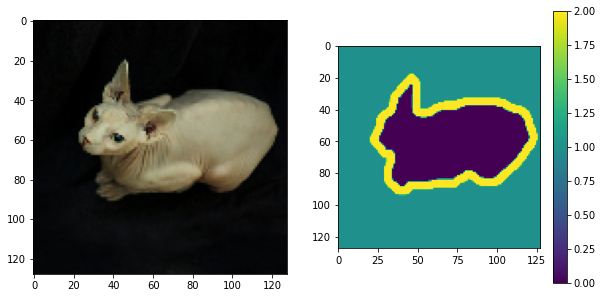

In [9]:
import matplotlib.pyplot as plt

for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(mask[0], axis=2))
    plt.colorbar()
    
    print(np.amax(img[0][2]), np.amin(img[0][2]))           

In [25]:
def REDNet_segmentation(num_layers):
    conv_layers=[]
    deconv_layers=[]
    residual_layers=[]
    
    inputs = tf.keras.layers.Input(shape=(None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))
    
    for i in range(num_layers -1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))
    
    x = conv_layers[0](inputs)
    
    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i %2 == 0:
            residual_layers.append(x)
        
    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x)
        
    x = deconv_layers[-1](x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [26]:
model = REDNet_segmentation(15)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.optimizers.Adam(0.0001), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, None, None, 3 84          input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, None, None, 6 1792        conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, None, None, 6 36928       conv2d_52[0][0]                  
______________________________________________________________________________________________

In [5]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

In [27]:
%%time
Hist = model.fit(train_dataset, epochs=20, steps_per_epoch=train_data_len//16, validation_data=test_dataset, validation_steps=test_data_len)

Epoch 1/20
230/230 [==============================] - 174s 737ms/step - loss: 0.9387 - accuracy: 0.5692 - val_loss: 0.8135 - val_accuracy: 0.5981
Epoch 2/20
230/230 [==============================] - 171s 743ms/step - loss: 0.7709 - accuracy: 0.6277 - val_loss: 0.7637 - val_accuracy: 0.6351
Epoch 3/20
230/230 [==============================] - 171s 744ms/step - loss: 0.6915 - accuracy: 0.6896 - val_loss: 0.7225 - val_accuracy: 0.6842
Epoch 4/20
230/230 [==============================] - 171s 745ms/step - loss: 0.6500 - accuracy: 0.7141 - val_loss: 0.6235 - val_accuracy: 0.7334
Epoch 5/20
230/230 [==============================] - 171s 745ms/step - loss: 0.6167 - accuracy: 0.7332 - val_loss: 0.6124 - val_accuracy: 0.7387
Epoch 6/20
230/230 [==============================] - 171s 744ms/step - loss: 0.5887 - accuracy: 0.7475 - val_loss: 0.6167 - val_accuracy: 0.7340
Epoch 7/20
230/230 [==============================] - 171s 745ms/step - loss: 0.5719 - accuracy: 0.7567 - val_loss: 0.5554 -

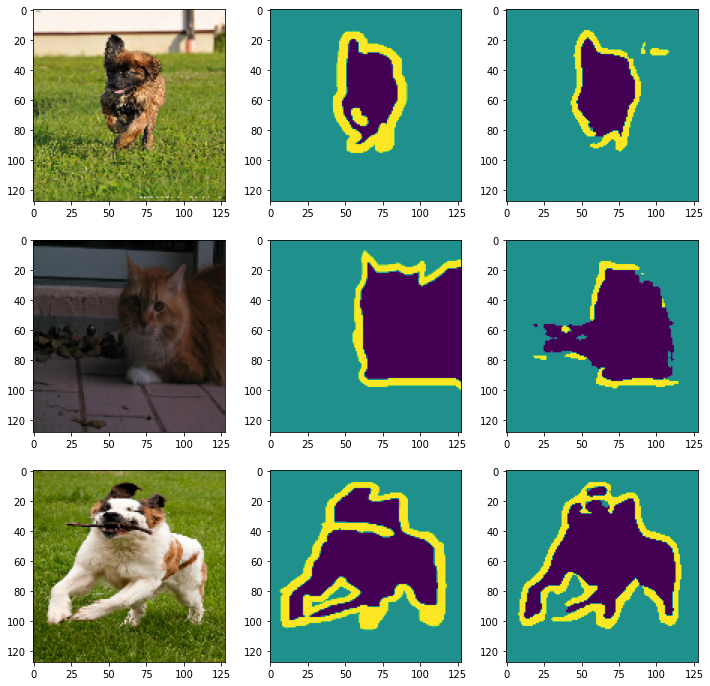

In [29]:
plt.figure(figsize=(12,12))

for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3,3,idx*3+1)
    plt.imshow(img[0])
    
    plt.subplot(3,3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))
    
    predict = tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3,3,idx*3+3)
    plt.imshow(np.squeeze(predict, axis=0))

mask tf.Tensor(
[[[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 ...

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]], shape=(500, 403, 1), dtype=uint8)
mask-1 tf.Tensor(
[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]], shape=(500, 403, 1), dtype=uint8)
mask: (500, 403, 1)
p: (500, 403)
img.shape (500, 403, 3)
mask tf.Tensor(
[[[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 ...

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]], shape=(225,

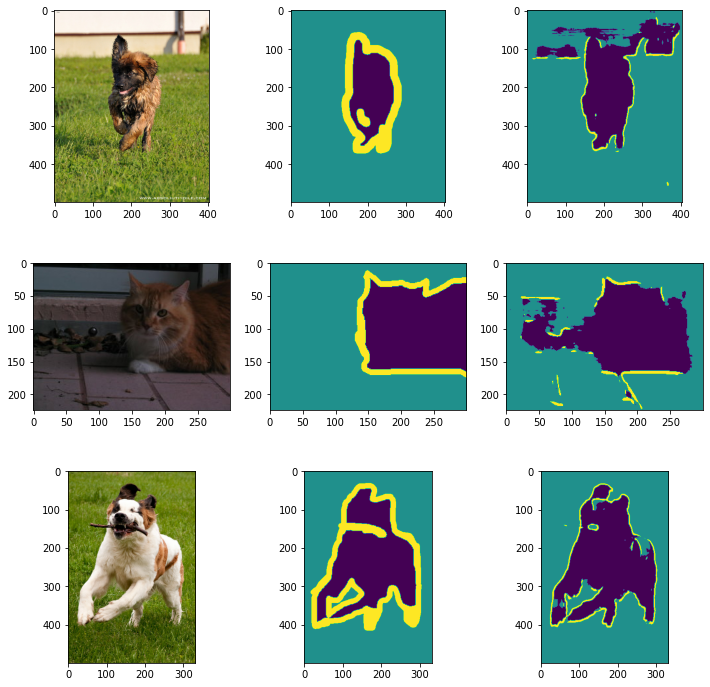

In [44]:
plt.figure(figsize=(12,12))

for idx, datapoint in enumerate(dataset['test'].take(3)):
    img = datapoint['image']
    mask = datapoint['segmentation_mask']
    
    img = tf.cast(img, tf.float32)
    img = img/255.0
    print('mask',mask)
    mask = mask-1
    print('mask-1',mask)
    
    plt.subplot(3,3,idx*3+1)
    plt.imshow(img)
    
    plt.subplot(3, 3, idx*3 + 2)
    plt.imshow(np.squeeze(mask, axis = 2))  # np.squeeze(mask) = (500, 403, 1) ->  (500, 403)

    predict=tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)  # expand_dims = (500,403,3) -> (1,500,403)
    plt.subplot(3,3,idx*3+3)
    plt.imshow(np.squeeze(predict, axis=0))